# ANN training

In [2]:
import os
import sys

from ase import Atoms, Atom, units
import ase.io
from ase.calculators.emt import EMT
from ase.build import add_adsorbate, fcc100, fcc110, fcc111
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md import VelocityVerlet
from ase.constraints import FixAtoms
from ase.md import MDLogger
from ase.md.langevin import Langevin

from amp import Amp
from amp.descriptor.gaussian import Gaussian
from amp.model.neuralnetwork import NeuralNetwork
from amp.model import LossFunction

print("You are all set for the tutorial.")

You are all set for the tutorial.


# ANN training #1: training on MD only

In [2]:
!rm -rf amp-*

zsh:1: no matches found: amp-*


In [3]:
! OMP_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 MKL_NUM_THREADS=1 PYTHONUNBUFFERED=1 "{sys.executable}" train_amp_1.py

In [4]:
!mv amp.amp amp_1.amp

In [1]:
from amp.analysis import plot_convergence

# plot_convergence("amp-log.txt")
! amp-plotconvergence amp-log.txt

1 convergence attempt(s) found.
Plotting data series 0.
/Users/inwon/anaconda3/bin/amp-plotconvergence:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pdf.savefig(fig)


### MD with ANN potential (amp_1.amp) start with hollow site

In [5]:
# initial structure
slab = fcc100('Al', size=(3, 3, 4))
add_adsorbate(slab, 'Au', 1.7, 'hollow')
slab.center(axis=2, vacuum=6.0)

# Fix third and fourth layers
constraint = FixAtoms(mask=[atom.tag > 2 for atom in slab])
slab.set_constraint(constraint)

# Enarlge slab to test fast ANN-MD
# (2, 2, 1) takes too long -> (1, 1, 1)
supercell = slab.repeat((1, 1, 1))

# Set the trained Amp as calculator
calc = Amp.load('amp_1.amp')
supercell.calc = calc

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(supercell, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(supercell, 2 * units.fs)  # 2 fs time step.
# dyn = Langevin(supercell, 2 * units.fs, temperature_K=300, friction=0.002)

# traj 파일 열기 (쓰기 모드, atoms 초기 상태 등록)
with ase.io.Trajectory('hollow.traj', 'w', supercell) as traj:
    # 5 스텝마다 원자 구조 저장
    dyn.attach(traj.write, interval=5)

    # 로그도 파일에 기록 (옵션)
    dyn.attach(MDLogger(dyn, supercell, 'hollow.log', header=True,
                        stress=False, peratom=False), interval=5)

    # 짧게 예열
    dyn.run(5000)

In [6]:
images = ase.io.read('hollow.traj', ':')
ase.io.write('hollow.extxyz', images)

/Users/inwon/anaconda3/lib/python3.11/site-packages/ase/io/extxyz.py:318: UserWarning: Skipping unhashable information adsorbate_info
  warnings.warn('Skipping unhashable information '


In [1]:
from matplotlib import pyplot as plt
import numpy as np

with open("hollow.log", 'r') as infile:
    lines = infile.readlines()
    
Time = []
Etot = []
Epot = []
Ekin = []
Temp = []
for line in lines[1:]:
    tmp = line.split()

    Time.append(tmp[0])
    Etot.append(tmp[1])
    Epot.append(tmp[2])
    Ekin.append(tmp[3])
    Temp.append(tmp[4])

Time = np.array(Time, dtype=np.float64)
Etot = np.array(Etot, dtype=np.float64)
Epot = np.array(Epot, dtype=np.float64)
Ekin = np.array(Ekin, dtype=np.float64)
Temp = np.array(Temp, dtype=np.float64)

In [4]:
print(Etot)

[7.6075 7.6076 7.6077 ... 7.6137 7.6135 7.6133]


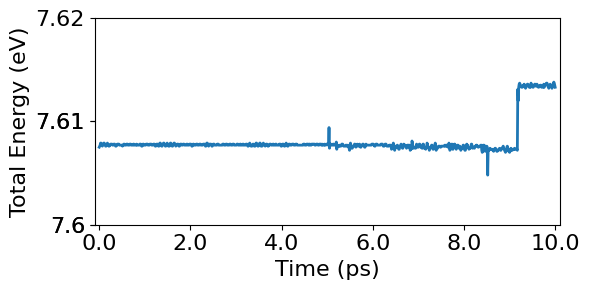

In [14]:
fig = plt.figure(figsize=(6, 3))
ax = fig.subplots()

font_x = {'size': 16, 'color': 'black'}
font_y = {'size': 16, 'color': 'black'}
font_tick = {'size': 16, 'color': 'black'}

# The first plot
ax.plot(Time, Etot, linestyle='-', color='tab:blue', linewidth=2, label='Original DFT')

ax.set_xlabel("Time (ps)", fontdict=font_x)
ax.set_xlim([-0.1, 10.1])
x_labels = [round(label, 2) for label in ax.get_xticks()]
ax.set_xticks(x_labels)
ax.set_xlim([-0.1, 10.1])
ax.set_xticklabels(x_labels, fontdict=font_tick)

ax.set_ylabel("Total Energy (eV)", fontdict=font_y)
ax.set_ylim([7.6, 7.62])
y_labels = [round(label, 2) for label in ax.get_yticks()]
ax.set_yticks(y_labels)
ax.set_ylim([7.6, 7.62])
ax.set_yticklabels(y_labels, fontdict=font_tick)

fig.tight_layout()
plt.show()

### MD with ANN potential (amp_1.amp) start with bridge site

In [3]:
# initial structure
slab = fcc100('Al', size=(3, 3, 4))
add_adsorbate(slab, 'Au', 1.7, 'bridge')
slab.center(axis=2, vacuum=6.0)

# Fix third and fourth layers
constraint = FixAtoms(mask=[atom.tag > 2 for atom in slab])
slab.set_constraint(constraint)

# Enarlge slab to test fast ANN-MD
# (2, 2, 1) takes too long -> (1, 1, 1)
supercell = slab.repeat((1, 1, 1))

# Set the trained Amp as calculator
calc = Amp.load('amp_1.amp')
supercell.calc = calc

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(supercell, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(supercell, 2 * units.fs)  # 2 fs time step.
# dyn = Langevin(supercell, 2 * units.fs, temperature_K=300, friction=0.002)

# traj 파일 열기 (쓰기 모드, atoms 초기 상태 등록)
with ase.io.Trajectory('bridge.traj', 'w', supercell) as traj:
    # 5 스텝마다 원자 구조 저장
    dyn.attach(traj.write, interval=5)

    # 로그도 파일에 기록 (옵션)
    dyn.attach(MDLogger(dyn, supercell, 'bridge.log', header=True,
                        stress=False, peratom=False), interval=5)

    # 짧게 예열
    dyn.run(1000)

In [4]:
images = ase.io.read('bridge.traj', ':')
ase.io.write('bridge.extxyz', images)

/Users/inwon/anaconda3/lib/python3.11/site-packages/ase/io/extxyz.py:318: UserWarning: Skipping unhashable information adsorbate_info
  warnings.warn('Skipping unhashable information '
